# Polynomial and regularized models
### Master's Degree in Artificial Intelligence - Universidad de los Andes
#### By: Pedro Trujillo Vargas

This project is related to environmental risk management. In this context, one of the problems that we are going to address is how to build a predictive model that allows us to determine the demand for the use of a bicycle rental system. This knowledge can provide support to improve the service and know the factors that affect its efficiency. Promoting sustainable mobility plans is a way to reduce CO2 emissions, which affect the planet's temperature and unbalance the natural cycle.

<a href="https://www.kaggle.com/datasets/imakash3011/rental-bike-sharing"><img src="https://storage.googleapis.com/kaggle-datasets-images/1541302/2541845/9e7f8bbfbee902a0ddd2e85f746aa2bd/dataset-cover.jpg?t=2021-08-19-16-35-15" width="200" height="100"></a>


#### Goals:

* Apply regression techniques to build a predictive model that allows **estimating the demand for the use of a bicycle rental system** following the machine learning cycle.

* Determine **which are the factors that most affect demand** based on the data.



## Activities to do:


1. [Data exploration and profiling](#1.-Data-exploration-and-profiling)
2. [Data cleaning and preparation](#2.-Data-cleaning-and-preparation)
3. [Construction of a polynomial regression model](#3.-Construction-of-a-polynomial-regression-model)
4. [Polynomial regression model Evaluation](#4.-Polynomial-regression-model-Evaluation)
5. [Construction of a Lasso regularized regression model](#5.-Construction-of-a-Lasso-regularized-regression-model)
6. [Lasso regularized regression model evaluation](#6.-Lasso-regularized-regression-model-evaluation)
7. [Comparison of metrics](#7.-Comparison-of-metrics)


To begin, we load the necessary python libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

### 1. Data exploration and profiling

Using the functionalities of the pandas library we will determine quality problems (for example, missing values ‚Äã‚Äãand duplicate records) and make decisions related to the preparation of the data for the learning algorithm.

#### Data Upload:

We will use **Pandas** to import the local file `./data_Etapa-1.xlsx` that contains the bike rental data set. As we can see, this file is in excel format, which is why we need to use the `read_excel (<path>)` function to load the data into our dataframe:


In [2]:
ruta = './data/datos_Etapa-1.xlsx'
df = pd.read_excel(ruta)
df.head()

season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0  Winter,6,Clear,3.2799999999999994,3.0014000000...                
1  Winter,6,Clear,2.34,1.9982000000000006,0.8,0.0...                
2  Winter,6,Clear,2.34,1.9982000000000006,0.8,0.0...                
3  Winter,6,Clear,3.2799999999999994,3.0014000000...                
4  Winter,6,Clear,3.2799999999999994,3.0014000000...

We can see that the data is not organized by columns, rather they are grouped as strings of characters in the same row/cell but separated by commas. Unfortunately the Pandas `read_excel` library does not allow comma separation, which lets us see that this file was most likely saved in the wrong format.

![como aprecen en excel](./assets/screeshot_datos_excel.png "hojas de c√°lculo de excel")

As part of data analysis it is necessary to prepare the data in a format that Pandas can interpret. To do this we have two options: convert this file to a comma-separated values ‚Äã‚Äã`*.csv` format to facilitate its analysis. We will do this from an Excel spreadsheet editor:


<img src="./assets/screeshot_como_guardar_datos_excel.png" width="500" height="200">

Or fix the malformed dataframe through the use of Pandas functions. For this exercise we will use the second option since the development of skills in managing data processing libraries such as Pandas is part of the academic objectives.

To do this, we will use the following code to iterate between all the rows and separate each string found by commas, which we know corresponds to an array of columns:


In [3]:
# reference: https://stackoverflow.com/questions/50091272/python-pandas-read-excel-sep-parameter-available
# fix the malformed dataframe based in the malformed excel:
df_raw = df.iloc[:, 0].str.split(',', expand=True)
df_raw.columns = [n.replace('"', '') for n in df.columns.str.split(',')[0]]
df_raw.head()

season weekday weathersit                temp               atemp   hum  \
0  Winter       6      Clear  3.2799999999999994  3.0014000000000003  0.81   
1  Winter       6      Clear                2.34  1.9982000000000006   0.8   
2  Winter       6      Clear                2.34  1.9982000000000006   0.8   
3  Winter       6      Clear  3.2799999999999994  3.0014000000000003  0.75   
4  Winter       6      Clear  3.2799999999999994  3.0014000000000003  0.75   

  windspeed cnt time_of_day  
0       0.0  16       Night  
1       0.0  40       Night  
2       0.0  32       Night  
3       0.0  13       Night  
4       0.0   1       Night

Now that we have an understandable dataframe, we will proceed to analyze the data. First let's look at what form they have and compare it with the data dictionary:

In [4]:
df_raw.shape

(17379, 9)

#### Description

To have more information about the data, we are going to proceed to describe these assets that they have to tell us:

In [5]:
df_raw.describe()

season weekday weathersit   temp               atemp    hum windspeed  \
count    17379   17379      17379  17379               17379  17379     17379   
unique       4       7          4     50                  65     89        30   
top     Summer       6      Clear  21.14  24.999200000000002   0.88       0.0   
freq      4496    2512      11413    726                 988    657      2180   

          cnt time_of_day  
count   17379       17379  
unique    869           3  
top         5       Night  
freq      260        6471

We see that these have several categorical variables, and numerical data of the integer and floating point type. It will be good to compare these observations with those provided by the data dictionary.

We load the data dictionary:

In [6]:
ruta_diccionario = './data/DiccionarioDatos_Etapa-1.xlsx'
diccionario = pd.read_excel(ruta_diccionario)
diccionario

Columna        Tipo                                      Descripci√≥n
0       season  categ√≥rica  Estaci√≥n del a√±o (Winter, Spring, Summer, Fall)
1      weekday    num√©rico                      D√≠a de la semana (de 1 a 7)
2   weathersit  categ√≥rica      Clima (Clear, Mist, Light Rain, Heavy Rain)
3         temp    num√©rico                                      Temperatura
4        atemp    num√©rico                         Sensaci√≥n de temperatura
5          hum    num√©rico                                          Humedad
6    windspeed    num√©rico                             Velocidad del viento
7          cnt    num√©rico                  Cantidad de bicicletas rentadas
8  time_of_day  categ√≥rica          Parte del d√≠a (Morning, Evening, Night)

We can see that according to the data dictionary, the shape of the dataframe corresponds to the correct number of variables, which is equal to 9:

In [7]:
assert df_raw.shape[1] == diccionario.shape[0], "The number of variables in the dataframe does not correspond to those recorded in the data dictionary"

#### Analysis

Now the data is clearer. Based on the first objective of our model _"estimate the demand for the use of a bicycle rental system"_, the data dictionary and the data analysis, it is possible to identify that the independent variable is **Number of bicycles rented** `cnt`. The variations in the data of this numerical variable will give us a better idea of ‚Äã‚Äãwhat the correlation is between the other variables and the demand for bicycle use.

Let's take a look at the current relationship and distribution of data. To do this, we will use scatter diagrams between the independent variables and the dependent variable, the number of bicycles rented **cnt**, this will give us an idea of ‚Äã‚Äãhow the data is distributed and related:

**Note: the graphics may take a while to load, please be patient.**

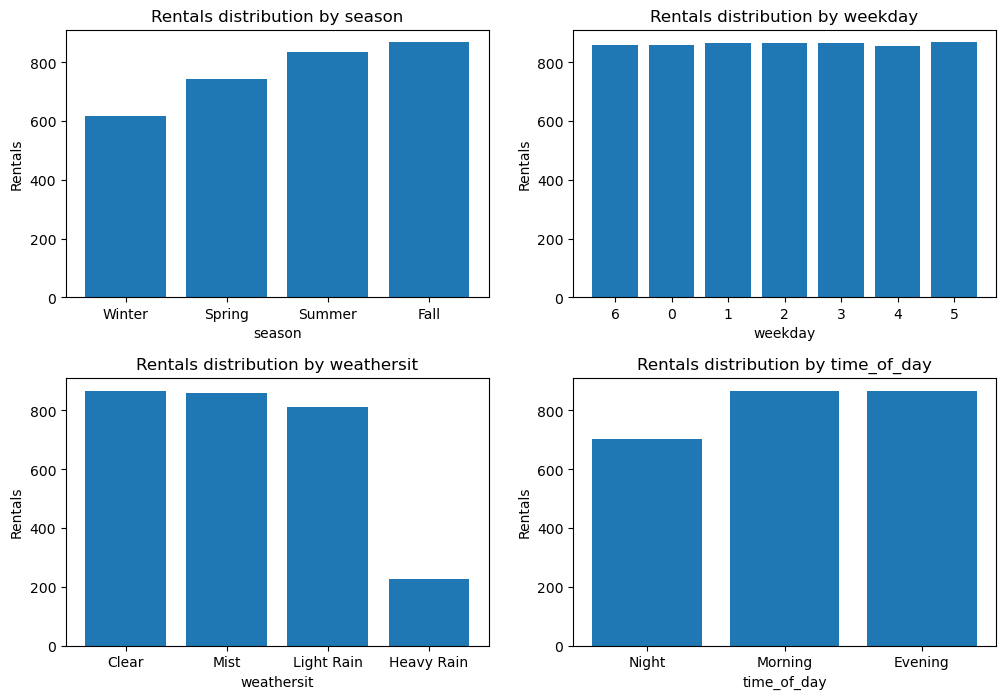

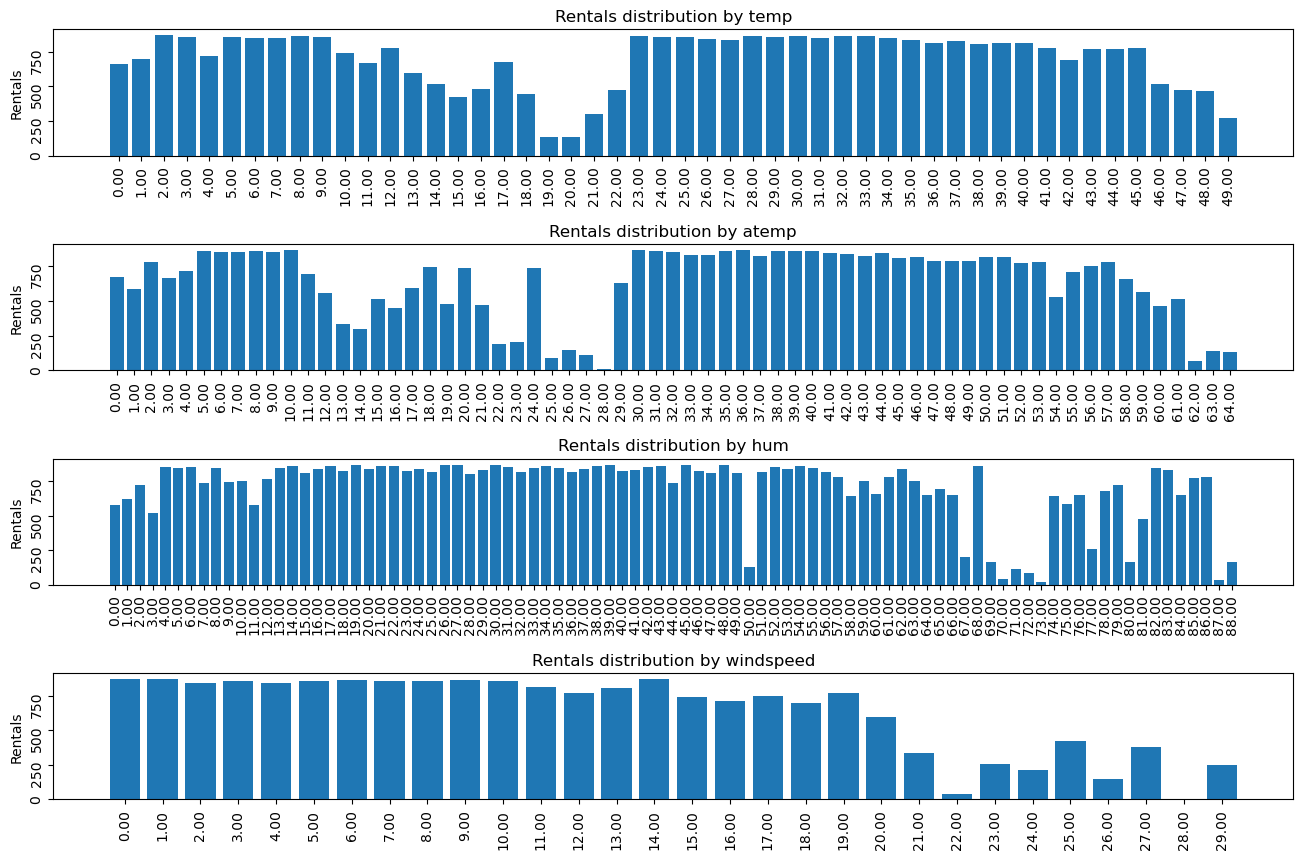

In [8]:
%matplotlib inline

x_data_categ = df_raw.drop(['cnt', 'windspeed', 'hum', 'atemp', 'temp'], axis=1)
x_data = df_raw.drop(['cnt', 'weekday', 'season', 'time_of_day', 'weathersit'], axis=1)
y_data = df_raw['cnt']

figure, axis = plt.subplots(2, 2, figsize=(12, 8))
flattenedAxis = axis.flatten()
plt.subplots_adjust(hspace = 0.3)

i = 0
for (columnName, columnData) in x_data_categ.items():  
    flattenedAxis[i].set_title('Rentals distribution by ' + columnName)
    flattenedAxis[i].bar(columnData, y_data)
    flattenedAxis[i].set_xlabel(columnName) 
    flattenedAxis[i].set_ylabel('Rentals')
    flattenedAxis[i].set_yscale('linear')
    i += 1
#     print(i)
    
plt.show()

figure2 , axis2 = plt.subplots(4, 1, figsize=(16, 10))
flattenedAxis2 = axis2.flatten()
plt.subplots_adjust(hspace = 0.7)

i = 0
for (columnName, columnData) in x_data.items(): 
    flattenedAxis2[i].set_title('Rentals distribution by ' + columnName)
    flattenedAxis2[i].bar(columnData, y_data)
    #flattenedAxis2[i].set_xlabel( columnName ) 
    flattenedAxis2[i].set_ylabel('Rentals')
    flattenedAxis2[i].set_yscale('linear')
    flattenedAxis2[i].tick_params(labelrotation=90)
    flattenedAxis2[i].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    i += 1
#     print(i)

plt.show()



From the graphs we can interpret that the rentals are low during winter `season`, that according `weathersit` rain or light rain conditions may discourage people to use this type of transportation,  and `time_of_day` do not greatly affect bicycle rentals. Also that increases in humidity `hum` cause bicycle use to destabilize, and the potential existence of a correlation between temperature `temp` and the sensation of temperature `atemp`. And high `windspeed` may discourage people from renting a bicycle as well.

We can see that there are 3 variables `season`, `weathersit` and `time_of_day` of categorical type which we must convert to numerical ones to better understand if these are correlated. At the moment we will not be able to calculate the correlation matrix in the dataset since this requires that all variables be numerical.

Before training any machine learning model, it is important to ensure that the data used does not contain errors, such as missing or duplicate data. For this it is advisable to use a new variable, in this case `data`, which we will use to store a modified data set:

In [9]:
data = df_raw

#### Verification of missing data:
Now we will check if the dataframe contains missing values:

In [10]:
data.isna().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

Apparently the dataframe does not contain missing data

#### Duplicate data check:

Now we will check if the dataframe contains duplicate values:

In [11]:
data.duplicated().sum()

42

Oh! The dataframe contains 42 duplicate data

### 2. Data cleaning and preparation

Cleaning and preparing the data, justifying the decisions made based on the results obtained in the previous step.

#### Duplicate removal

Since the dataset contains 42 duplicate data, it is necessary to remove them from it as part of the data cleaning process:

In [12]:
data = data.drop_duplicates()
data.duplicated().sum()

0

#### Conversion of categorical variables into numerical ones

As part of the data preparation we must convert the three categorical variables to numerical ones, otherwise we will not be able to use them to generate the correlation matrix nor will we be able to train our model. To do this we will use the `get_dummies` function from the Pandas library. This takes as input the dataframe and an array with the name of the categorical columns that we want to convert. This will return the dummy values ‚Äã‚Äãfor all the categorical columns that we designate:

In [13]:
data = pd.get_dummies(data, columns = ['weekday', 'season', 'weathersit','time_of_day'])

Now let's look at what the data looks like after converting the categorical values ‚Äã‚Äãto numeric!

In [14]:
data.head()

temp               atemp   hum windspeed cnt  weekday_0  \
0  3.2799999999999994  3.0014000000000003  0.81       0.0  16          0   
1                2.34  1.9982000000000006   0.8       0.0  40          0   
2                2.34  1.9982000000000006   0.8       0.0  32          0   
3  3.2799999999999994  3.0014000000000003  0.75       0.0  13          0   
4  3.2799999999999994  3.0014000000000003  0.75       0.0   1          0   

   weekday_1  weekday_2  weekday_3  weekday_4  ...  season_Spring  \
0          0          0          0          0  ...              0   
1          0          0          0          0  ...              0   
2          0          0          0          0  ...              0   
3          0          0          0          0  ...              0   
4          0          0          0          0  ...              0   

   season_Summer  season_Winter  weathersit_Clear  weathersit_Heavy Rain  \
0              0              1                 1                      0   
1              0              1                 1                      0   
2              0              1                 1                      0   
3              0              1                 1                      0   
4              0              1                 1                      0   

   weathersit_Light Rain  weathersit_Mist  time_of_day_Evening  \
0                      0                0                    0   
1                      0                0                    0   
2                      0                0                    0   
3                      0                0                    0   
4                      0                0                    0   

   time_of_day_Morning  time_of_day_Night  
0                    0                  1  
1                    0                  1  
2                    0                  1  
3                    0                  1  
4                    0                  1  

[5 rows x 23 columns]

In [15]:
data.shape

(17337, 23)

We see that the dimensions of our dataframe have changed, we went from 9 variables to 23! ü§Ø This is because several of the categorical variables were converted to numerical ones represented with 1 and 0 where 1 expresses the existence of this one, now numerical, in the row that previously contained this one as categorical.

There are other ways to convert categorical variables to numerical ones such as [scikit Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html) but since we do not want the model to give priority to some numerical categories more than others we prefer to use [scikit Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html) from the Pandas library.

Since we have all the data numerically, we can obtain a new description of it such as the mean, the standard deviation, among others:

In [16]:
data.describe()

weekday_0     weekday_1     weekday_2     weekday_3     weekday_4  \
count  17337.000000  17337.000000  17337.000000  17337.000000  17337.000000   
mean       0.143912      0.142643      0.140855      0.142355      0.142239   
std        0.351010      0.349718      0.347882      0.349423      0.349305   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          weekday_5     weekday_6   season_Fall  season_Spring  season_Summer  \
count  17337.000000  17337.000000  17337.000000   17337.000000   17337.000000   
mean       0.143277      0.144719      0.243468       0.253792       0.258984   
std        0.350366      0.351828      0.429187       0.435193       0.438089   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%        0.000000      0.000000      0.000000       0.000000       0.000000   
50%        0.000000      0.000000      0.000000       0.000000       0.000000   
75%        0.000000      0.000000      0.000000       1.000000       1.000000   
max        1.000000      1.000000      1.000000       1.000000       1.000000   

       season_Winter  weathersit_Clear  weathersit_Heavy Rain  \
count   17337.000000      17337.000000           17337.000000   
mean        0.243756          0.656919               0.000173   
std         0.429360          0.474752               0.013154   
min         0.000000          0.000000               0.000000   
25%         0.000000          0.000000               0.000000   
50%         0.000000          1.000000               0.000000   
75%         0.000000          1.000000               0.000000   
max         1.000000          1.000000               1.000000   

       weathersit_Light Rain  weathersit_Mist  time_of_day_Evening  \
count           17337.000000     17337.000000         17337.000000   
mean                0.081329         0.261579             0.294053   
std                 0.273348         0.439507             0.455629   
min                 0.000000         0.000000             0.000000   
25%                 0.000000         0.000000             0.000000   
50%                 0.000000         0.000000             0.000000   
75%                 0.000000         1.000000             1.000000   
max                 1.000000         1.000000             1.000000   

       time_of_day_Morning  time_of_day_Night  
count         17337.000000       17337.000000  
mean              0.334372           0.371575  
std               0.471784           0.483240  
min               0.000000           0.000000  
25%               0.000000           0.000000  
50%               0.000000           0.000000  
75%               1.000000           1.000000  
max               1.000000           1.000000

We see that some data are not described to us, apparently they are still interpreted as non-numeric, therefore we should make them numerical. Let's first look at the data type with `data.dtypes`:

In [17]:
data.dtypes

temp                     object
atemp                    object
hum                      object
windspeed                object
cnt                      object
weekday_0                 uint8
weekday_1                 uint8
weekday_2                 uint8
weekday_3                 uint8
weekday_4                 uint8
weekday_5                 uint8
weekday_6                 uint8
season_Fall               uint8
season_Spring             uint8
season_Summer             uint8
season_Winter             uint8
weathersit_Clear          uint8
weathersit_Heavy Rain     uint8
weathersit_Light Rain     uint8
weathersit_Mist           uint8
time_of_day_Evening       uint8
time_of_day_Morning       uint8
time_of_day_Night         uint8
dtype: object

AHA! Now let's proceed to convert the object type columns into numeric ones. For that we will use `pd.to_numeric(<column>)`:

In [18]:
data["temp"] = pd.to_numeric(data["temp"])
data["atemp"] = pd.to_numeric(data["atemp"])
data["hum"] = pd.to_numeric(data["hum"])
data["windspeed"] = pd.to_numeric(data["windspeed"])
data["cnt"] = pd.to_numeric(data["cnt"])
data.dtypes

temp                     float64
atemp                    float64
hum                      float64
windspeed                float64
cnt                        int64
weekday_0                  uint8
weekday_1                  uint8
weekday_2                  uint8
weekday_3                  uint8
weekday_4                  uint8
weekday_5                  uint8
weekday_6                  uint8
season_Fall                uint8
season_Spring              uint8
season_Summer              uint8
season_Winter              uint8
weathersit_Clear           uint8
weathersit_Heavy Rain      uint8
weathersit_Light Rain      uint8
weathersit_Mist            uint8
time_of_day_Evening        uint8
time_of_day_Morning        uint8
time_of_day_Night          uint8
dtype: object

Let's see what the data looks like now.

In [19]:
data.head()

temp   atemp   hum  windspeed  cnt  weekday_0  weekday_1  weekday_2  \
0  3.28  3.0014  0.81        0.0   16          0          0          0   
1  2.34  1.9982  0.80        0.0   40          0          0          0   
2  2.34  1.9982  0.80        0.0   32          0          0          0   
3  3.28  3.0014  0.75        0.0   13          0          0          0   
4  3.28  3.0014  0.75        0.0    1          0          0          0   

   weekday_3  weekday_4  ...  season_Spring  season_Summer  season_Winter  \
0          0          0  ...              0              0              1   
1          0          0  ...              0              0              1   
2          0          0  ...              0              0              1   
3          0          0  ...              0              0              1   
4          0          0  ...              0              0              1   

   weathersit_Clear  weathersit_Heavy Rain  weathersit_Light Rain  \
0                 1                      0                      0   
1                 1                      0                      0   
2                 1                      0                      0   
3                 1                      0                      0   
4                 1                      0                      0   

   weathersit_Mist  time_of_day_Evening  time_of_day_Morning  \
0                0                    0                    0   
1                0                    0                    0   
2                0                    0                    0   
3                0                    0                    0   
4                0                    0                    0   

   time_of_day_Night  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  

[5 rows x 23 columns]

In [20]:
data.describe()

temp         atemp           hum     windspeed           cnt  \
count  17337.000000  17337.000000  17337.000000  17337.000000  17337.000000   
mean      15.373723     15.419489      0.626924     12.744552    189.865836   
std        9.046797     11.338895      0.192857      8.196736    181.400275   
min       -7.060000    -16.000000      0.000000      0.000000      1.000000   
25%        7.980000      5.997800      0.480000      7.001500     40.000000   
50%       15.500000     15.996800      0.630000     12.998000    143.000000   
75%       23.020000     24.999200      0.780000     16.997900    281.000000   
max       39.000000     50.000000      1.000000     56.996900    977.000000   

          weekday_0     weekday_1     weekday_2     weekday_3     weekday_4  \
count  17337.000000  17337.000000  17337.000000  17337.000000  17337.000000   
mean       0.143912      0.142643      0.140855      0.142355      0.142239   
std        0.351010      0.349718      0.347882      0.349423      0.349305   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...  season_Spring  season_Summer  season_Winter  weathersit_Clear  \
count  ...   17337.000000   17337.000000   17337.000000      17337.000000   
mean   ...       0.253792       0.258984       0.243756          0.656919   
std    ...       0.435193       0.438089       0.429360          0.474752   
min    ...       0.000000       0.000000       0.000000          0.000000   
25%    ...       0.000000       0.000000       0.000000          0.000000   
50%    ...       0.000000       0.000000       0.000000          1.000000   
75%    ...       1.000000       1.000000       0.000000          1.000000   
max    ...       1.000000       1.000000       1.000000          1.000000   

       weathersit_Heavy Rain  weathersit_Light Rain  weathersit_Mist  \
count           17337.000000           17337.000000     17337.000000   
mean                0.000173               0.081329         0.261579   
std                 0.013154               0.273348         0.439507   
min                 0.000000               0.000000         0.000000   
25%                 0.000000               0.000000         0.000000   
50%                 0.000000               0.000000         0.000000   
75%                 0.000000               0.000000         1.000000   
max                 1.000000               1.000000         1.000000   

       time_of_day_Evening  time_of_day_Morning  time_of_day_Night  
count         17337.000000         17337.000000       17337.000000  
mean              0.294053             0.334372           0.371575  
std               0.455629             0.471784           0.483240  
min               0.000000             0.000000           0.000000  
25%               0.000000             0.000000           0.000000  
50%               0.000000             0.000000           0.000000  
75%               1.000000             1.000000           1.000000  
max               1.000000             1.000000           1.000000  

[8 rows x 23 columns]

‚ú®The data is much cleaner now! üòå

#### Elimination of irrelevant variables

Before eliminating data that is not relevant to our analysis, it is necessary to identify if there is non-relevant data and, if so, know what it is. In this case Pandas can easily help us obtain the correlation matrix of the dataframe we are working with:

In [21]:
correlation_matrix = data.corr(numeric_only = True) #use numeric values only!
correlation_matrix

temp     atemp       hum  windspeed       cnt  \
temp                   1.000000  0.987660 -0.069881  -0.023781  0.404155   
atemp                  0.987660  1.000000 -0.051948  -0.062856  0.400335   
hum                   -0.069881 -0.051948  1.000000  -0.290057 -0.322245   
windspeed             -0.023781 -0.062856 -0.290057   1.000000  0.092539   
cnt                    0.404155  0.400335 -0.322245   0.092539  1.000000   
weekday_0             -0.027727 -0.024197  0.001605  -0.006574 -0.027254   
weekday_1             -0.004298  0.000099  0.017409  -0.004094 -0.012909   
weekday_2              0.024483  0.026965  0.026034   0.006607  0.004947   
weekday_3              0.020833  0.018737  0.037758  -0.009500  0.003972   
weekday_4              0.021316  0.022046 -0.037141   0.005838  0.015494   
weekday_5             -0.001647 -0.009833 -0.028266  -0.012569  0.014659   
weekday_6             -0.032486 -0.033324 -0.017125   0.020252  0.001205   
season_Fall           -0.217963 -0.198625  0.117331  -0.089448  0.029453   
season_Spring          0.144292  0.151921 -0.000871   0.063195  0.060508   
season_Summer          0.642385  0.619415  0.018249  -0.089440  0.151407   
season_Winter         -0.583823 -0.587449 -0.135021   0.116618 -0.245257   
weathersit_Clear       0.101198  0.101610 -0.383390   0.005821  0.117463   
weathersit_Heavy Rain -0.021232 -0.022142  0.017491   0.001482 -0.008379   
weathersit_Light Rain -0.062306 -0.068175  0.308980   0.068855 -0.127471   
weathersit_Mist       -0.069927 -0.066695  0.221444  -0.049157 -0.047352   
time_of_day_Evening    0.188607  0.178855 -0.368751   0.198341  0.472196   
time_of_day_Morning   -0.079594 -0.077598  0.132754  -0.040353  0.003346   
time_of_day_Night     -0.100123 -0.092877  0.218075  -0.147612 -0.448484   

                       weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
temp                   -0.027727  -0.004298   0.024483   0.020833   0.021316   
atemp                  -0.024197   0.000099   0.026965   0.018737   0.022046   
hum                     0.001605   0.017409   0.026034   0.037758  -0.037141   
windspeed              -0.006574  -0.004094   0.006607  -0.009500   0.005838   
cnt                    -0.027254  -0.012909   0.004947   0.003972   0.015494   
weekday_0               1.000000  -0.167237  -0.166013  -0.167040  -0.166961   
weekday_1              -0.167237   1.000000  -0.165157  -0.166179  -0.166100   
weekday_2              -0.166013  -0.165157   1.000000  -0.164962  -0.164884   
weekday_3              -0.167040  -0.166179  -0.164962   1.000000  -0.165904   
weekday_4              -0.166961  -0.166100  -0.164884  -0.165904   1.000000   
weekday_5              -0.167671  -0.166806  -0.165585  -0.166610  -0.166531   
weekday_6              -0.168655  -0.167785  -0.166557  -0.167587  -0.167508   
season_Fall             0.005953  -0.001574   0.005583  -0.001107  -0.001690   
season_Spring          -0.004612   0.005826   0.000091   0.007450  -0.001462   
season_Summer          -0.010940  -0.006953   0.004376   0.002950   0.012193   
season_Winter           0.009886   0.002763  -0.010138  -0.009455  -0.009270   
weathersit_Clear        0.042226  -0.015829  -0.031153  -0.019916   0.011492   
weathersit_Heavy Rain  -0.005394   0.007174  -0.005327   0.007190  -0.005357   
weathersit_Light Rain  -0.020390  -0.020593   0.022077   0.055126  -0.013627   
weathersit_Mist        -0.032769   0.029691   0.020080  -0.012988  -0.003778   
time_of_day_Evening     0.000482  -0.000432   0.003611  -0.000624  -0.000411   
time_of_day_Morning    -0.003224   0.001783  -0.000188   0.002369  -0.000196   
time_of_day_Night       0.002693  -0.001333  -0.003221  -0.001724   0.000579   

                       ...  season_Spring  season_Summer  season_Winter  \
temp                   ...       0.144292       0.642385      -0.583823   
atemp                  ...       0.151921       0.619415      -0.587449   
hum                    ...      -0.000871       0.018249

The correlation matrix represents the matrix of correlation coefficients between the variables of the dataframe, where 0 means that there is no correlation, or they are independent variables; a negative value means they are negatively correlated; and a positive value means that they are positively correlated. This means that for a negative correlation, as its value increases the other decreases, and for a positive correlation if its value increases the other will also do so.

In order to better understand this correlation we are going to use the `heatmap` function of the [seaborn](https://seaborn.pydata.org/examples/many_pairwise_correlations.html) library which will show us the variables that are mostly correlated as the hot points of the matrix:

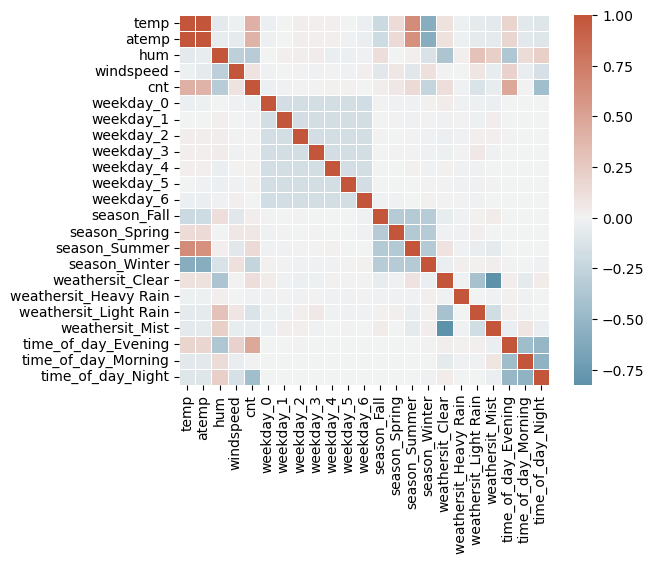

In [22]:
# Generate a custom diverging colormap
cmap = sn.diverging_palette(230, 20, as_cmap=True)
sn.heatmap(correlation_matrix, cmap=cmap, square=True, linewidths=.5, center=0) # add , annot=True for annotations 
plt.show()

Based on the correlation matrix and the hot spot graph, we observe that some variables have a correlation coefficient very close to zero, as is the case of the weekday variable, which we could put forward some hypotheses:

* `weekday` is not very relevant and could be removed when implementing the Lasso regression
* Temperature and temperature sensation are important factors that create variations in rents
*Not many bikes are rented at night
* Winter is a determining factor in the reduction in bicycle rentals.

<!-- * important: As you can see, the coefficient of the variables bedrooms, sqft_lot and sqft_lot15 is 0, which implies that this model does not take these variables into account to make predictions. One of the peculiarities of Lasso regression is that, thanks to the use of the penalty term, it is capable of determining variables that are not relevant for the estimation of the target variable. Usually this selection of variables occurs with large values ‚Äã‚Äãof the alpha hyperparameter, which implies that the regularization is also much greater. This result can be used to, for example, establish the most relevant variables and train a different model on the subset of variables obtained.-->

### 3. Construction of a polynomial regression model

To determine the degree of the polynomial transformation, model selection techniques are used on the following polynomial degree values: [2, 3]. Use the RMSE metric for selection.


#### Data preparation

Initially we are going to separate the target variable `cnt` from the independent variables. We will use the data variable to construct two sets of variables:

* Create a variable `x` from the data of independent variables
* Create a variable `y` from the data of dependent variable `cnt`

In [23]:
x = data.drop(["cnt"], axis=1)
y = data["cnt"]
x.head()

temp   atemp   hum  windspeed  weekday_0  weekday_1  weekday_2  weekday_3  \
0  3.28  3.0014  0.81        0.0          0          0          0          0   
1  2.34  1.9982  0.80        0.0          0          0          0          0   
2  2.34  1.9982  0.80        0.0          0          0          0          0   
3  3.28  3.0014  0.75        0.0          0          0          0          0   
4  3.28  3.0014  0.75        0.0          0          0          0          0   

   weekday_4  weekday_5  ...  season_Spring  season_Summer  season_Winter  \
0          0          0  ...              0              0              1   
1          0          0  ...              0              0              1   
2          0          0  ...              0              0              1   
3          0          0  ...              0              0              1   
4          0          0  ...              0              0              1   

   weathersit_Clear  weathersit_Heavy Rain  weathersit_Light Rain  \
0                 1                      0                      0   
1                 1                      0                      0   
2                 1                      0                      0   
3                 1                      0                      0   
4                 1                      0                      0   

   weathersit_Mist  time_of_day_Evening  time_of_day_Morning  \
0                0                    0                    0   
1                0                    0                    0   
2                0                    0                    0   
3                0                    0                    0   
4                0                    0                    0   

   time_of_day_Night  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  

[5 rows x 22 columns]

We see that the dependent variable `cnt` is not in the data of `x`. Now let's look at what `y` looks like:

In [24]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

Now we will use 80% of the data to train the model and the remaining 20% ‚Äã‚Äãto test it, this separation of sets will be applied to the data of the variables `x` and `y`. Also when doing the training ‚Äì test split it uses a seed value of 77 `ramdon_state`. The result of this operation will be four variables: `x_train`, `x_test`, `y_train` and `y_test` which will store the training and test data according to their name.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=77)

Let's review what the training data `x` looks like:


In [26]:
x_train.head()

temp    atemp   hum  windspeed  weekday_0  weekday_1  weekday_2  \
7697   9.86   9.9974  0.94    15.0013          0          0          1   
5830  23.96  26.0024  0.74    11.0014          0          1          0   
4589  20.20  22.9994  0.73    12.9980          0          0          0   
6726  17.38  18.0032  0.94     7.0015          0          0          0   
6150  17.38  18.0032  0.68     6.0032          1          0          0   

      weekday_3  weekday_4  weekday_5  ...  season_Spring  season_Summer  \
7697          0          0          0  ...              0              0   
5830          0          0          0  ...              0              1   
4589          0          0          1  ...              0              1   
6726          1          0          0  ...              0              0   
6150          0          0          0  ...              0              1   

      season_Winter  weathersit_Clear  weathersit_Heavy Rain  \
7697              0                 0                      0   
5830              0                 0                      0   
4589              0                 1                      0   
6726              0                 0                      0   
6150              0                 0                      0   

      weathersit_Light Rain  weathersit_Mist  time_of_day_Evening  \
7697                      1                0                    0   
5830                      1                0                    0   
4589                      0                0                    0   
6726                      1                0                    0   
6150                      0                1                    0   

      time_of_day_Morning  time_of_day_Night  
7697                    1                  0  
5830                    1                  0  
4589                    0                  1  
6726                    0                  1  
6150                    0                  1  

[5 rows x 22 columns]

Let's also review what the training data `y` looks like:

In [27]:
y_train.head()

7697    190
5830    152
4589      7
6726     90
6150    180
Name: cnt, dtype: int64

Next we will standardize the data. Initially, it is necessary to store the names of the training set columns in the temporary variable `columns`:

In [28]:
columns = x_train.columns

And we will define an object of the class `RobustScaler()`, which will do the standardization:

In [29]:
robustScaler = RobustScaler() 

The reason we will implement `RobustScaler()` is because the data may have outliers or extremes that could skew the results of our model, that is why `RobustScaler()` uses robust statistics against outliers, that is That is, it generates much larger values, compared to for example `StandardScaler()` for more information: [robust vs standar scaler](https://proclusacademy.com/blog/robust-scaler-outliers/#:~:text=The%20robust%20scaler%20produces%20a,outliers%20and%20other%20data%20points.). To see this compare the data with what was initially shown before cleaning the data from the following sample `describe()` after having applied the standardization transformer.  In this comparison you can see that the data is now centered on zero:
* We will apply the standardization transformer `RobustScaler()` to the training data `x_train`
* We will then rebuild the dataframe using the columns temporarily saved in `columns`

In [30]:
x_train = robustScaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train,columns=columns)
x_train.describe()

temp         atemp           hum     windspeed     weekday_0  \
count  13869.000000  13869.000000  13869.000000  13869.000000  13869.000000   
mean      -0.008806     -0.030578     -0.009873     -0.026544      0.144351   
std        0.599866      0.594682      0.642520      0.814422      0.351458   
min       -1.500000     -1.683918     -2.100000     -1.300268      0.000000   
25%       -0.500000     -0.526224     -0.500000     -0.599866      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.500000      0.473776      0.500000      0.400134      0.000000   
max        1.562500      1.789510      1.233333      4.401475      1.000000   

          weekday_1     weekday_2     weekday_3     weekday_4     weekday_5  \
count  13869.000000  13869.000000  13869.000000  13869.000000  13869.000000   
mean       0.140529      0.140673      0.141683      0.144062      0.143774   
std        0.347548      0.347697      0.348737      0.351166      0.350873   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...  season_Spring  season_Summer  season_Winter  weathersit_Clear  \
count  ...   13869.000000   13869.000000   13869.000000      13869.000000   
mean   ...       0.254164       0.257481       0.243493         -0.341409   
std    ...       0.435406       0.437262       0.429205          0.474199   
min    ...       0.000000       0.000000       0.000000         -1.000000   
25%    ...       0.000000       0.000000       0.000000         -1.000000   
50%    ...       0.000000       0.000000       0.000000          0.000000   
75%    ...       1.000000       1.000000       0.000000          0.000000   
max    ...       1.000000       1.000000       1.000000          0.000000   

       weathersit_Heavy Rain  weathersit_Light Rain  weathersit_Mist  \
count           13869.000000           13869.000000     13869.000000   
mean                0.000216               0.081765         0.259428   
std                 0.014706               0.274016         0.438336   
min                 0.000000               0.000000         0.000000   
25%                 0.000000               0.000000         0.000000   
50%                 0.000000               0.000000         0.000000   
75%                 0.000000               0.000000         1.000000   
max                 1.000000               1.000000         1.000000   

       time_of_day_Evening  time_of_day_Morning  time_of_day_Night  
count         13869.000000         13869.000000       13869.000000  
mean              0.294830             0.334631           0.370539  
std               0.455983             0.471878           0.482966  
min               0.000000             0.000000           0.000000  
25%               0.000000             0.000000           0.000000  
50%               0.000000             0.000000           0.000000  
75%               1.000000             1.000000           1.000000  
max               1.000000             1.000000           1.000000  

[8 rows x 22 columns]

#### Hyperparameter search and model training

Now with the data set prepared, it is time to train the multivariable polynomial regression model. As a first step we will define a function with the name PolynomialRegression(), used to perform the search for hyperparameters:

In [31]:
def PolynomialRegression():
    return make_pipeline(
        PolynomialFeatures(),
        RobustScaler(),
        LinearRegression()
    )

Why do we use linear regression in the above function, is it because polynomial regression is linear regression? [Although polynomial regression fits a nonlinear model to the data, as a statistical estimation problem it is linear, in the sense that the regression function E(y | x) is linear in the unknown parameters that are estimated from the data.](https://en.wikipedia.org/wiki/Polynomial_regression#:~:text=Although%20polynomial%20regression%20fits%20a,are%20estimated%20from%20the%20data.)

Now we will use an object of the `KFold` class, with which we will define 10 subsets on the training data `x_train` with the same `random_state=77`:

In [32]:
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

Now we will determine the degree of the polynomial transformation, for this we will define the hyperparameter search space. For this, we will create a dictionary called `parameters_grid` whose key is `polynomialfeatures__degree` and with a tuple value (2,3) that corresponds to the degrees of the polynomial to be evaluated:

In [33]:
parameters_grid = { "polynomialfeatures__degree": [2,3] }

Now that we have all the necessary elements for the hyperparameter search, we will do this through the hyperparameter optimization method [Grid Search](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search), which will be responsible for doing an exhaustive or brute force search through the parameters defined in the `polynomialfeatures__degree` dictionary. For this, just create an object[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), which will be in charge of automating the search for us ü§ó. We will call this object `grid_search_curve_validation` and we will use the `PolynomialRegression()` function as input parameters, in addition to the param_grid and `kfold` variables to define it. And also the input parameter `scoring='neg_root_mean_squared_error'`, this in order to select RMSE as the evaluation metric in the search:

In [34]:
grid_search_curve_validation = GridSearchCV(PolynomialRegression(), parameters_grid, cv=kfold, n_jobs=-1, scoring='neg_root_mean_squared_error')

All ready! Let's do the hyperparameter search using the training set, composed of the variables `x_train` and `y_train`. To do this, just call the `fit()` method of our GridSearchCV object `grid_search_curve_validation` using the training data `x_train` and `y_train`.

In [35]:
grid_search_curve_validation.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('robustscaler', RobustScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'polynomialfeatures__degree': [2, 3]},
             scoring='neg_root_mean_squared_error')

At this point we can answer our first question of the exercise: **What is the degree of the polynomial transformation that was selected using the validation technique?** To observe the best estimated parameter we only have to access the `best_params_ property ` of the GridSearchCV object:

In [36]:
grid_search_curve_validation.best_params_

{'polynomialfeatures__degree': 3}

#### üéâ The best degree of the polynomial transformation estimated was = 3

Based on this, let's see which was the best estimated model, and let's wait for it in the variable `best_model`:

In [37]:
grid_search_mejor_modelo = grid_search_curve_validation.best_estimator_
grid_search_mejor_modelo

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('robustscaler', RobustScaler()),
                ('linearregression', LinearRegression())])

### 4. Polynomial regression model Evaluation



We will now evaluate the trained model using the test set. For this we will first standardize the data of the test set `x_test`, using the object of type `RobustScaler()` called `robustScaler` that we instantiated previously and then we will reconstruct the dataframe using the temporary variable `columns`

**Important:** Since this time we will be scaling the test data, we will only invoke the `transform(..)` method of the RobustScaler() object, the reason for this is because this transformation is being done on the test data set. try which do not need to be trained. For more information about transformers watch the video I invite you to watch this [video](https://www.youtube.com/watch?v=BotYLBQfd5M):

In [38]:
x_test = robustScaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=columns)
x_test.shape

(3468, 22)

We are ready to make predictions üîÆ! To do this, simply invoke the `predict()` method of our `grid_search_best_model`, passing it the test data set `x_test`, this will be done in order to compare the predictions with the real values ‚Äã‚Äãstored in `y_test`. The results of the predictions will be saved in a variable `y_predictions` for these comparisons:

In [39]:
y_predictions = grid_search_mejor_modelo.predict(x_test)
y_predictions

array([ -4.99798584, 185.58392334, 267.89331055, ..., 241.52581787,
       221.32580566, 215.44613647])

Time for the evaluation of our model ‚úÖ For this we will select the metrics [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) using the function `mean_squared_error(‚Ä¶)`, `mean_absolute_error(‚Ä¶)` and `r2_score(‚Ä¶)` of [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) which they receive as input parameters `y_test` and `y_predictions`:

In [40]:
polinomial_RMSE = mean_squared_error(y_test, y_predictions, squared=False)
polinomial_MAE = mean_absolute_error(y_test, y_predictions)
polinomial_R2 = r2_score(y_test, y_predictions)

print("RMSE: %.2f" % polinomial_RMSE)
print("MAE: %.2f" % polinomial_MAE)
print("R¬≤: %.2f" % polinomial_R2)

RMSE: 130.39
MAE: 94.12
R¬≤: 0.49


### 5. Construction of a Lasso regularized regression model

In this section we will do the parameter search and evaluation but this time for a Lasso regularized regression model. To do this we will start using the same training parameters `x_train` and `y_train` that we used for the polynomial regression.

#### Hyperparameter search and model training

Based on the previously defined training set we will begin with the creation of our model. To determine the value of the regularization hyperparameter we will use model selection techniques on the following values ‚Äã‚Äãfor **Œ±**: [1, 2, 3, 4, 5]. For this we will define a dictionary type variable with the name `alpha_param_grid` with a tuple equal to `[1, 2, 3, 4, 5]` and whose key is `alpha`:


In [41]:
alpha_parameters_grid = { "alpha":[1, 2, 3, 4, 5] }

Now, we will define the object of the **Lasso** class to perform training with regularized regression:


In [42]:
lasso = Lasso()

We will also reuse the object of the `KFold` class, of 10 subsets on the training set we defined earlier. Now with all the necessary elements, the last step before performing the hyperparameter search is to create the object of type GridSearchCV with the variables `lasso`, `alpha_parameters_grid` and `kfold`, `scoring='neg_root_mean_squared_error'` and which we will call `alpha_grid_search_curve_validation`:

In [43]:
alpha_grid_search_curve_validation = GridSearchCV( lasso, alpha_parameters_grid, cv=kfold, scoring='neg_root_mean_squared_error' )

All ready! Let's do the hyperparameter search using the training set, composed of the variables `x_train` and `y_train`. To do this, just call the `fit()` method of our GridSearchCV object `alpha_grid_search_curve_validation` using the training data `x_train` and `y_train`.

In [44]:
alpha_grid_search_curve_validation.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=Lasso(), param_grid={'alpha': [1, 2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

Super! At this point we can answer our second question of the exercise: **What was the value of Œ± that was selected using the validation technique for the Lasso regression?** To observe the best parameter **Œ±** estimated only we must access the `best_params_` property of the GridSearchCV object:

In [45]:
alpha_grid_search_curve_validation.best_params_

{'alpha': 1}

#### üéâ **The value of Œ± that was selected using the validation technique for Lasso regression was = 1**

Based on this, let's see which was the best estimated model, and let's wait for it in the variable `best_model` which we will call `alpha_grid_search_best_model`:

In [46]:
alpha_grid_search_mejor_modelo = alpha_grid_search_curve_validation.best_estimator_
alpha_grid_search_mejor_modelo

Lasso(alpha=1)

At this point we can answer our fourth question of the exercise **Which variables were selected with the Lasso model? Based on these, what interpretation of the problem can you give?** To observe the coefficients obtained and, subsequently, to perform the tests:


In [47]:
list(zip(x_train.columns, alpha_grid_search_mejor_modelo.coef_))

[('temp', 59.96323032928045),
 ('atemp', 39.934889659259404),
 ('hum', -44.70236300625479),
 ('windspeed', -0.0),
 ('weekday_0', -1.8186377549792645),
 ('weekday_1', -0.0),
 ('weekday_2', -0.0),
 ('weekday_3', 0.0),
 ('weekday_4', 0.0),
 ('weekday_5', 0.0),
 ('weekday_6', 0.0),
 ('season_Fall', 47.74915967120022),
 ('season_Spring', 15.322878201887974),
 ('season_Summer', -3.094704845196768),
 ('season_Winter', -6.689443869775115),
 ('weathersit_Clear', 1.5254761171624927),
 ('weathersit_Heavy Rain', 0.0),
 ('weathersit_Light Rain', -28.106375413452778),
 ('weathersit_Mist', -0.0),
 ('time_of_day_Evening', 84.70372728226413),
 ('time_of_day_Morning', 0.0),
 ('time_of_day_Night', -99.35748368745818)]

#### üéâ The variables selected with the Lasso model were:
`weekday_0`, `temp`, `atemp`, `hum`, `season_Fall`, `season_Spring`, `season_Summer`, `weathersit_Clear`, `weathersit_Light Rain`, `time_of_day_Evening` y `time_of_day_Night`

#### What interpretation of the problem can you give?

As we can see, the coefficient of the variables, `weekday_{1...6}` `windspeed`, `weathersit_Heavy Rain`, `weathersit_Mist` and `time_of_day_Morning` is **0**, which means that this model It does not take these variables into account to make predictions.

_One of the peculiarities of Lasso regression is that, thanks to the use of the penalty term, it is capable of determining variables that are not relevant for the estimation of the target variable. Usually this selection of variables occurs with large values ‚Äã‚Äãof the alpha hyperparameter, which implies that the regularization is also much greater. This result can be used to, for example, establish the most relevant variables and train a different model on the subset of variables obtained._

Which was a total surprise, since based on the data analysis, distribution and correlation graphs, some of our previous bets were different! Below we will illustrate which were correct and which were not:

* `weekday` is not very relevant and could be removed when implementing the Lasso regression‚ùå: Apparently, this variable is relevant to the model although in a low proportion given by `weekday_0`.
* Temperature and the sensation of temperature are important factors that create variations in rentals ‚úÖ: We were right, variations in temperature greatly influence the decision to rent a bicycle.
* Not many bicycles are rented at night ‚úÖ: Clearly, this variable is inversely correlated to a large extent, which means that for some reason people avoid renting bicycles at night in the place where the data was generated.
* Winter is a determining factor in the reduction in bicycle rentals ‚ùå: Although it is inversely correlated, surprisingly not to the large extent that we expected.

Some extra surprises:
* Since these data were taken in a place on the planet affected by seasons, we were able to find that:
* The time of day when most people rent bicycles is the night between 6 pm and 10 pm or dusk `time_of_day_Evening`. This could be due to peak hours where many people return home and are not eager to arrive at a specific time.
* Service users love the dry breeze of Autumn, we can see this reflected in `season_Fall` which has a significant value compared to the parameters of the other seasons.
* In contrast, although not so surprising, it seems that users of the service do not like wet days to ride a bicycle. We can see this in the value of the `hum` coefficient which is inversely correlated.
* Apparently on Sundays some people do not usually rent bicycles.


### 6. Lasso regularized regression model evaluation

We are ready to make predictions üîÆ! We will evaluate the trained model using the test set.  To do this, simply invoke the `predict(..)` method of our `alpha_grid_search_best_model`, passing it the test data set `x_test`, this will be done in order to compare the predictions with the real values ‚Äã‚Äãstored in `y_test`. The results of the predictions will be saved in a variable `y_lasso_predictions` for these comparisons:

In [48]:
y_lasso_predictions = alpha_grid_search_mejor_modelo.predict(x_test)
y_lasso_predictions

array([ 87.0830688 , 140.68474039, 246.15725574, ..., 247.68273186,
       259.49915564, 182.32029005])

Time to evaluate our model ‚úÖ For this we will select the metrics [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation):

In [49]:
lasso_RMSE = mean_squared_error(y_test, y_lasso_predictions, squared=False)
lasso_MAE = mean_absolute_error(y_test, y_lasso_predictions)
lasso_R2 = r2_score(y_test, y_lasso_predictions)

print("RMSE: %.2f" % lasso_RMSE)
print("MAE: %.2f" % lasso_MAE)
print("R¬≤: %.2f" % lasso_R2)

RMSE: 139.77
MAE: 103.43
R¬≤: 0.42


### 7. Comparison of metrics


**From the comparative table, which model offers the best performance on the test set? What interpretation can you give to the values ‚Äã‚Äãobtained from the performance metrics?**

Let's find out:


|      | Polynomials | Lasso |
|------|------------|-------|
| RMSE |     130.39       |   139.77    |
| MAE  |     94.12       |   103.43    |
| R¬≤   |     0.49       |   0.42    |


From which we can conclude that:

#### üéâ The model offers the best performance on the test set: the Lasso regularized regression model


#### üéâ The interpretation that we can give to the values ‚Äã‚Äãobtained from the performance metrics is:

With respect to the polynomial regression model, the mean absolute error value, as well as the value of the root mean square error are a little larger, but the R2 value was low which means that for the data set, Generalization performance shows improvements with L1 regularization and an `alpha` value of 1, although not significant.
It would be good to do a better refinement of the parameters to obtain a model with better performance.


We have come this far in this exercise, it was hard iterative work that we hope you liked. Do not hesitate to send any questions you have to pe.trujillo@uniandes.edu.co

Thank you very much for your attention.

Sincerely,

Pedro.